# Preprocess images

In [4]:
!pip install torchstain[torch] --quiet

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os

import torch
from torchvision import transforms

import torchstain

import copy

In [32]:
# Convenience functions

BASE_DIR = './'

DATA_DIR = BASE_DIR + 'data/'
DATA_PROCESSED_DIR = BASE_DIR + 'data_processed/'

id2loc = lambda id_: DATA_DIR + f'img_{id_}.png'
id2img = lambda id_: Image.open(id2loc(id_))
img2arr = lambda img: np.array(img)
id2arr = lambda id_: img2arr(id2img(id_))

imgt2img = lambda imgt: transforms.ToPILImage()(imgt)
imgt2arr = lambda imgt: img2arr(imgt2img(imgt))

# Load labels
labels = pd.read_csv('data/labels.csv', sep=',')
# Convert to >= 0
labels["malignant"] += 1

label2text = {
    0: 'negative',
    1: 'benign',
    2: 'malignant'
}
text2label = {v: k for k, v in label2text.items()}

labels.head(10)

id  malignant
0     441          0
1   33284          0
2   38771          2
3   46784          0
4   57613          0
5   74682          1
6   78884          1
7   93760          1
8   98327          1
9  112905          1

In [21]:
labels_negative = labels[labels["malignant"]==0]
labels_benign = labels[labels["malignant"]==1]
labels_malignant = labels[labels["malignant"]==2]

print("Number of negative labels: ", len(labels_negative))
print("Number of benign labels: ", len(labels_benign))
print("Number of malignant labels: ", len(labels_malignant))
print("Total number of labels: ", len(labels))

Number of negative labels:  36
Number of benign labels:  14
Number of malignant labels:  12
Total number of labels:  62


## Data exploration

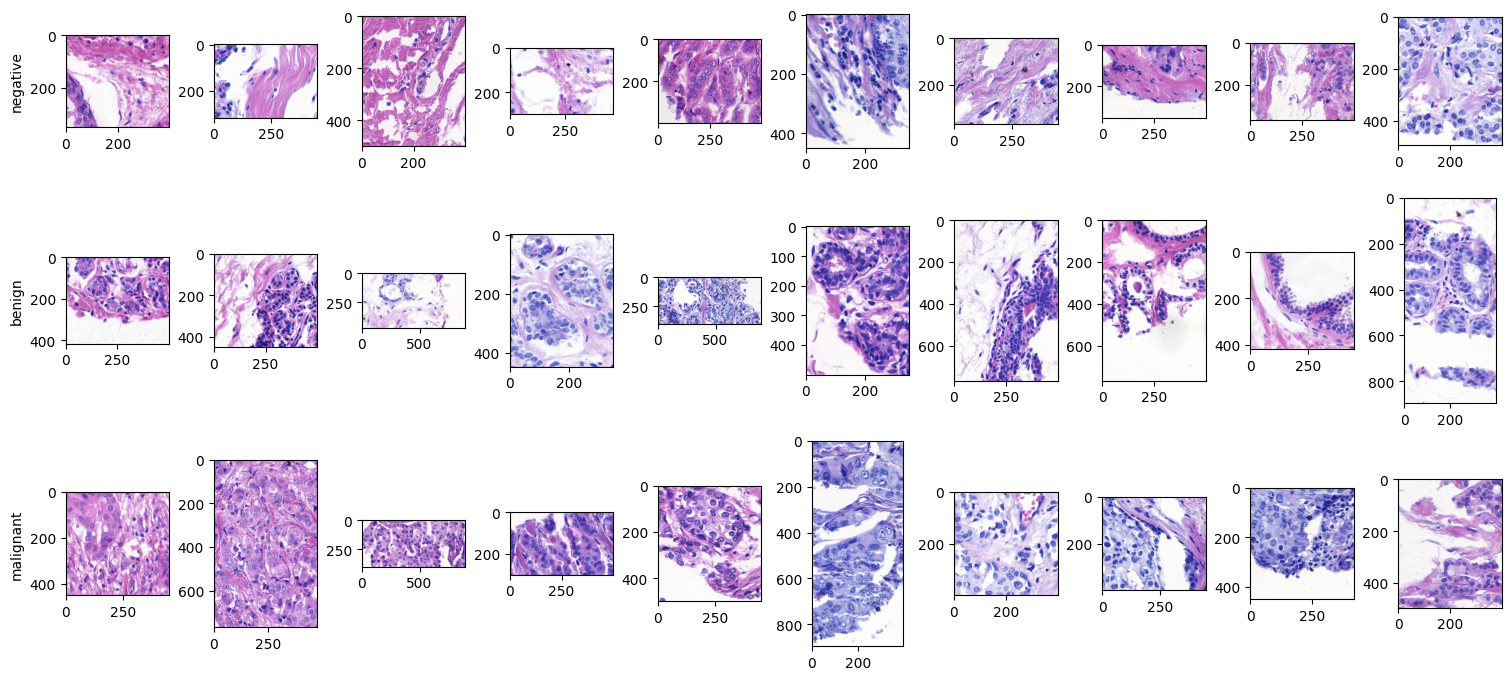

In [22]:
# Plot some images for each category

n_fig = 10
fig, axes = plt.subplots(3, n_fig, figsize=(15, 7), constrained_layout=True)

for i in range(n_fig):
    axes[0, i].imshow(id2arr(labels_negative.iloc[i]["id"]))
    axes[1, i].imshow(id2arr(labels_benign.iloc[i]["id"]))
    axes[2, i].imshow(id2arr(labels_malignant.iloc[i]["id"]))
for key, val in label2text.items():
    axes[key, 0].set_ylabel(val);

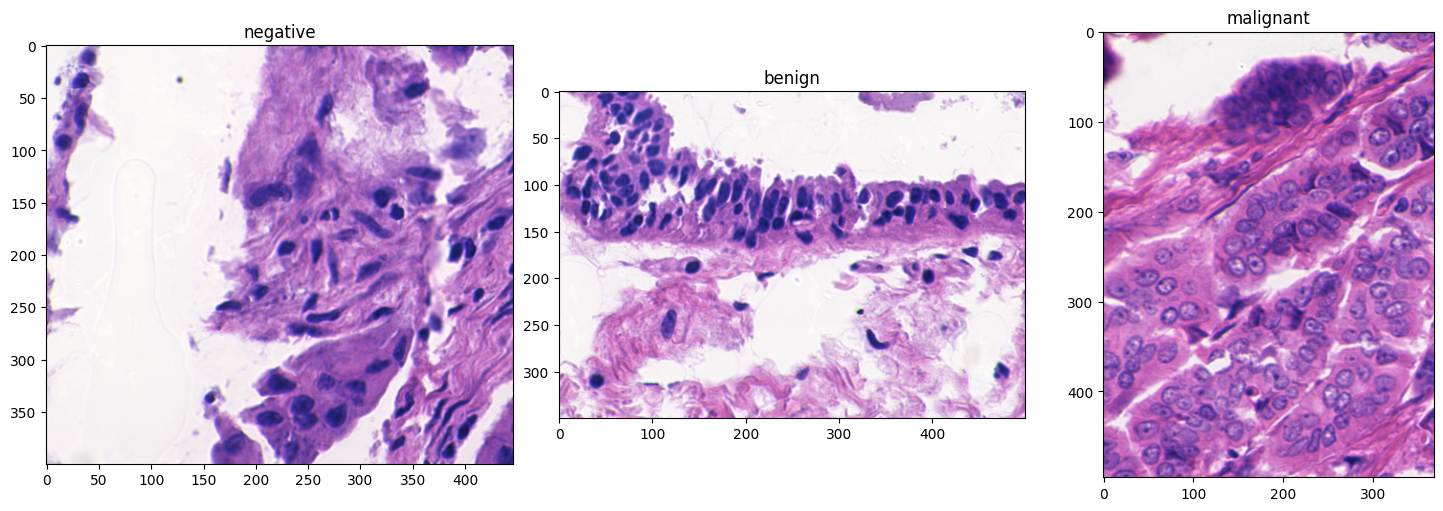

In [23]:
# Plot some in more detail

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].imshow(id2arr(labels_negative.iloc[11]["id"]))
axes[1].imshow(id2arr(labels_benign.iloc[11]["id"]))
axes[2].imshow(id2arr(labels_malignant.iloc[11]["id"]))
for key, val in label2text.items():
    axes[key].set_title(val);

In [24]:
dims = [id2arr(labels.iloc[i]["id"]).shape for i in range(len(labels))]
dims = pd.DataFrame(dims, columns=["width", "height", "channels"])
dims.describe()

width      height  channels
count   62.000000   62.000000      62.0
mean   469.548387  464.516129       3.0
std    149.680937  144.946428       0.0
min    268.000000  300.000000       3.0
25%    368.000000  400.000000       3.0
50%    446.000000  419.500000       3.0
75%    496.000000  490.750000       3.0
max    896.000000  896.000000       3.0

In [25]:
# maximum width or height
max_dim = max(dims["width"].max(), dims["height"].max())
max_dim

896

## Preprocessing

In [26]:
target_img = id2img(labels_malignant.iloc[11]["id"])

# staining library preprocessing
stain_trafo = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x*255),
    ]
)

# fit stain normalizer on target image
stain_normalizer = torchstain.normalizers.MacenkoNormalizer(backend="torch")
stain_normalizer.fit(stain_trafo(target_img))

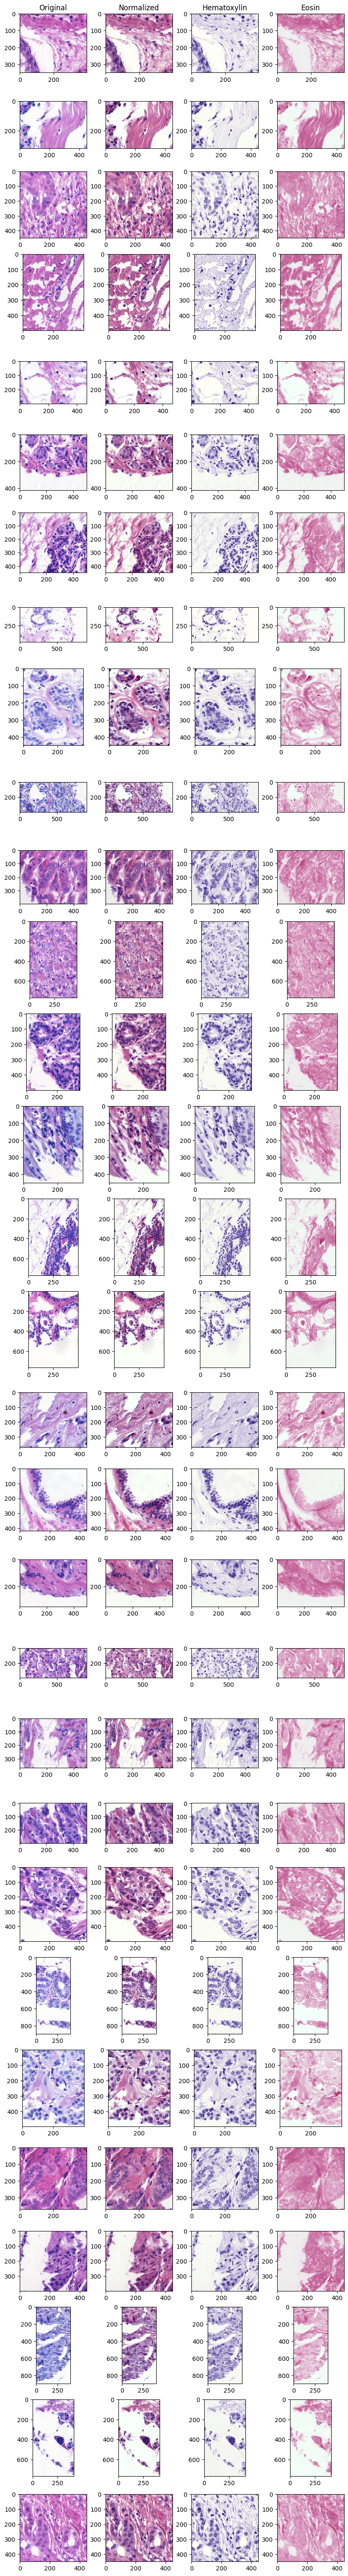

In [29]:
# Plot original vs. normalized images
n_img = 30
fig, axes = plt.subplots(n_img, 4, figsize=(4 * 2, n_img * 2), constrained_layout=True)
for ix in range(n_img):
    img = id2img(labels["id"][ix])
    norm, H, E = stain_normalizer.normalize(I=stain_trafo(img), stains=True)
    axes[ix, 0].imshow(img)
    axes[ix, 1].imshow(norm)
    axes[ix, 2].imshow(H)
    axes[ix, 3].imshow(E)
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Normalized")
axes[0, 2].set_title("Hematoxylin")
axes[0, 3].set_title("Eosin");

In [46]:
# Convert all images from DATA_DIR to normalized images in NORMALIZED_DATA_DIR

os.makedirs(DATA_PROCESSED_DIR, exist_ok=True)
os.makedirs(DATA_PROCESSED_DIR + "norm/", exist_ok=True)
os.makedirs(DATA_PROCESSED_DIR + "H/", exist_ok=True)
os.makedirs(DATA_PROCESSED_DIR + "E/", exist_ok=True)

# Iterate over files in DATA_DIR
for f in os.listdir(DATA_DIR):
    if not f.endswith(".png"):
        continue

    # Load image
    img = Image.open(DATA_DIR + f)
    # Normalize
    norm, H, E = stain_normalizer.normalize(I=stain_trafo(img), stains=True)
    # To Image
    norm = Image.fromarray(norm.numpy().astype(np.uint8))
    H = Image.fromarray(H.numpy().astype(np.uint8))
    E = Image.fromarray(E.numpy().astype(np.uint8))
    # Save image
    norm.save(DATA_PROCESSED_DIR + "norm/" + f)
    H.save(DATA_PROCESSED_DIR + "H/" + f)
    E.save(DATA_PROCESSED_DIR + "E/" + f)